<a href="https://colab.research.google.com/github/ruslanmv/Times-Series-with-Deep-Learning/blob/master/Forecast_of_Natural_Gas_Price_with_Deep_Learning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Forecast of Natural Gas Price with  Deep Learning

The following notebook details the process of training a neural network with LSTM models.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt                       
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from datetime import date
from datetime import datetime
today = date.today()
print("Today's date:", today)
to_today = datetime.strptime(str(today), '%Y-%m-%d').strftime('%d/%m/%Y')
to_date = datetime.strptime(str(today), '%Y-%m-%d').strftime('%Y-%m-%d')

Today's date: 2022-07-11


In [3]:
def addonDays(a, x):
   ret = time.strftime("%Y-%m-%d",time.localtime(time.mktime(time.strptime(a,"%Y-%m-%d"))+x*3600*24+3600))      
   return ret

In [4]:
week_ago=addonDays(to_date, -7)
week_ago

'2022-07-04'

In [6]:
!pip install investpy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.5 MB/s 
     |████████████████████████████████| 235 kB 49.5 MB/s 
     |████████████████████████████████| 6.4 MB 33.2 MB/s 
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481592 sha256=33be645f98066f19f473aed839d66082e57d603042477ccdfbaab57aab2b39e3
  Stored in directory: /root/.cache/pip/wheels/96/a8/a5/0d33c72eaf00b41df7b9dc1e15d2b7c7154b3f1379ed350211
Successfully built investpy
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Searching the Financial  Data

The search function allows the user to tune the parameters to adjust the search results to their needs, where both product types and countries from where the products are, can be specified.

For this project we are looking for the price of **Natural Gas and Crude Oil**

In [7]:
import investpy

gas_result = investpy.search_quotes(text='Natural Gas', products=['stocks'],
                                       countries=['united states'], n_results=1)

In [8]:
print(gas_result)

{"id_": 20413, "name": "Northwest Natural Gas Co", "symbol": "NWN", "country": "united states", "tag": "/equities/northwest-natural-gas-comp", "pair_type": "stocks", "exchange": "NYSE"}


Retrieved search results will be a list. those search results let the user retrieve both recent and historical data,

In [9]:
recent_data = gas_result.retrieve_recent_data()
print(recent_data.head())

             Open   High    Low  Close   Volume  Change Pct
Date                                                       
2022-06-13  53.31  53.56  51.28  51.51   214539       -4.77
2022-06-14  51.19  51.70  50.10  50.81   257471       -1.36
2022-06-15  50.94  51.63  50.51  50.81   337460        0.00
2022-06-16  50.28  51.01  49.69  50.86   428673        0.10
2022-06-17  51.43  51.99  50.56  51.69  1419987        1.63


Its information, the technical indicators, the default currency, etc., as presented in the piece of code below:

In [10]:
historical_data = gas_result.retrieve_historical_data(from_date='01/01/2022', to_date=to_today)
print(historical_data.head())

             Open   High    Low  Close  Volume  Change Pct
Date                                                      
2022-01-03  48.90  49.37  48.21  48.77  181573       -0.02
2022-01-04  49.10  49.79  49.08  49.35  131969        1.19
2022-01-05  49.47  49.89  49.24  49.57  126793        0.45
2022-01-06  49.72  49.74  49.27  49.54  130718       -0.06
2022-01-07  49.55  49.98  49.17  49.80  131915        0.52


In [11]:
information = gas_result.retrieve_information()
print(information)

{'prevClose': 52.06, 'dailyRange': '51.8-52.79', 'revenue': 894760000, 'open': 52.26, 'weekRange': '43.07-57.63', 'eps': 2.42, 'volume': 156807, 'marketCap': 1790000000, 'dividend': '1.93(3.71%)', 'avgVolume': 282206, 'ratio': 21.53, 'beta': 0.45, 'oneYearReturn': '0.12%', 'sharesOutstanding': 34255926, 'nextEarningDate': '11/08/2022'}


In [12]:
default_currency = gas_result.retrieve_currency()
print(default_currency)

USD


In [13]:
technical_indicators = gas_result.retrieve_technical_indicators(interval='daily')
print(technical_indicators)

              indicator    value           signal
0               RSI(14)  48.9150          neutral
1            STOCH(9,6)  45.0020          neutral
2          STOCHRSI(14)  19.5070         oversold
3           MACD(12,26)   0.2100              buy
4               ADX(14)  11.1960          neutral
5           Williams %R -60.4200             sell
6               CCI(14) -39.8620          neutral
7               ATR(14)   1.3331  less_volatility
8        Highs/Lows(14)   0.0000          neutral
9   Ultimate Oscillator  51.6290              buy
10                  ROC   1.4510              buy
11  Bull/Bear Power(13)  -0.9120             sell


In [14]:
import investpy

hist = investpy.get_stock_historical_data(stock='NWN',
                                        country='United States',
                                        from_date='01/01/2022',
                                        to_date=to_today)
print(hist.head())

             Open   High    Low  Close  Volume Currency
Date                                                   
2022-01-03  48.90  49.37  48.21  48.77  181573      USD
2022-01-04  49.10  49.79  49.08  49.35  131969      USD
2022-01-05  49.47  49.89  49.24  49.57  126793      USD
2022-01-06  49.72  49.74  49.27  49.54  130718      USD
2022-01-07  49.55  49.98  49.17  49.80  131915      USD


In [15]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=hist.index,y=hist['Close'], mode='lines'))
fig.update_layout(title={'text':gas_result.name+' ('+ default_currency +')', 'x':0.5})
fig.show()

Drawing an indicator 20 Day Moving Average , pandas provides convenient ways to calculate time series-related metrics such as the moving average. The df.rolling() method provides “moving windows” that we can operate on. To get the average of the moving window, we just need to add the .mean() at the end of the rolling() method.

In [16]:
from plotly.subplots import make_subplots

In [17]:
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Candlestick(x=hist.index,
                              open=hist['Open'],
                              high=hist['High'],
                              low=hist['Low'],
                              close=hist['Close'],
                             ))
fig2.add_trace(go.Scatter(x=hist.index,y=hist['Close'].rolling(window=20).mean(),marker_color='blue',name='20 Day MA'))
fig2.add_trace(go.Bar(x=hist.index, y=hist['Volume'], name='Volume'),secondary_y=True)
fig2.update_layout(title={'text':gas_result.name+' ('+ default_currency +')', 'x':0.5})
fig2.update_yaxes(range=[0,1000000000],secondary_y=True)
fig2.update_yaxes(visible=False, secondary_y=True)
fig2.update_layout(xaxis_rangeslider_visible=False)  #hide range slider
fig2.show()

## Creation of Dataframe

In [18]:
hist['Date'] = hist.index

In [19]:
df = hist[["Date", "Close"]]
df=df.reset_index(drop=True)

In [20]:
df.head()

,Date,Close
0,2022-01-03,48.77
1,2022-01-04,49.35
2,2022-01-05,49.57
3,2022-01-06,49.54
4,2022-01-07,49.80


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    130 non-null    datetime64[ns]
 1   Close   130 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


In [22]:
df.Date = pd.to_datetime(df.Date)

In [23]:
df = df.set_index("Date")
df.head()

,Close
Date,
2022-01-03,48.77
2022-01-04,49.35
2022-01-05,49.57
2022-01-06,49.54
2022-01-07,49.80


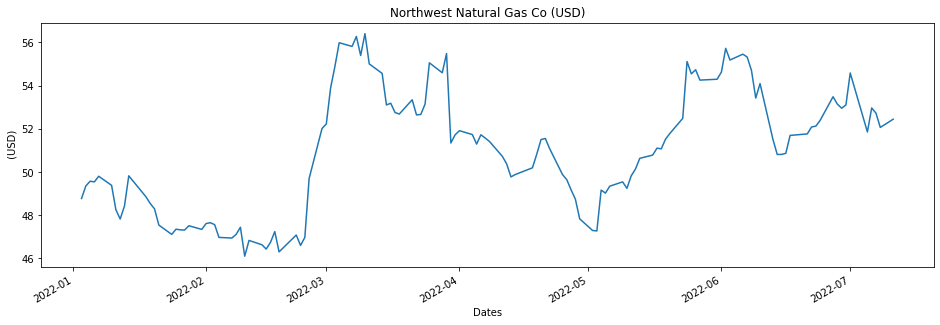

In [24]:
ax = df['Close'].plot(figsize = (16,5), title = gas_result.name+' ('+ default_currency +')')
ax.set(xlabel='Dates', ylabel=' ('+ default_currency +')');

## LSTM model training

#### Pre-processing data with MinMaxScaler

In [25]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2)

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [27]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating the LSTM model, we need to create a Time Series Generator object.

In [28]:
from keras.preprocessing.sequence import TimeseriesGenerator
# Let's redefine to get 24 days  back and then predict the next day out
n_input = 24
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, 
                                length=n_input, batch_size=1)

#### Example of transformation

In [29]:
X,y = generator[0]

In [30]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.52524272 0.93398058 0.54271845 0.2592233  0.31456311 0.90194175
 0.16699029 0.61067961 0.55145631 0.8815534  0.1368932  0.86407767
 0.64271845 0.20873786 0.14174757 0.44854369 0.31553398 0.13009709
 0.25631068 0.28349515 0.29805825 0.3184466  0.04854369 0.        ]
Predict this y: 
 [[0.83786408]]


# Long short-term memory  (LSTM)


Long short-term memory is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. Such a recurrent neural network can process not only single data points, but also entire sequences of data.

## Single LSTM Model

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
80/80 [==============================] - 2s 9ms/step - loss: 0.1657
Epoch 2/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0820
Epoch 3/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0840
Epoch 4/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0816
Epoch 5/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0776
Epoch 6/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0774
Epoch 7/20
80/80 [==============================] - 1s 8ms/step - loss: 0.0741
Epoch 8/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0774
Epoch 9/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0777
Epoch 10/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0783
Epoch 11/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0741
Epoch 12/20
80/80 [==============================] - 1s 9ms/step - loss: 0.0728
Epoch 13/20
80/80 [==============================

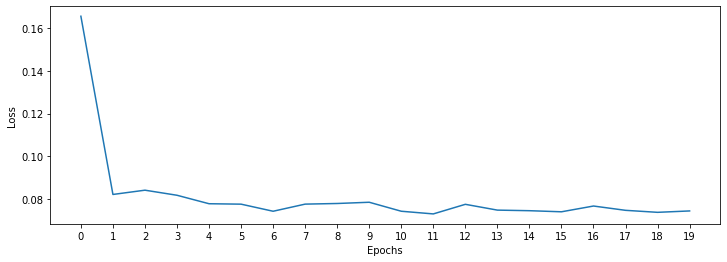

In [33]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

## Prediction on test data

Next we are going to make a prediction for 12 days (12 predictions). To do this we will do the following:
- create an empty list for each of our 12 predictions
- create the batch that our model will predict
- save the prediction in our list
- add the prediction to the end of the batch to use it in the next prediction

In [34]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As you know, we scale our data, so we have to invert it to see true predictions.

In [35]:
lstm_predictions_scaled

[array([0.49829352], dtype=float32),
 array([0.49820265], dtype=float32),
 array([0.4988584], dtype=float32),
 array([0.498628], dtype=float32),
 array([0.49799594], dtype=float32),
 array([0.4969852], dtype=float32),
 array([0.49583432], dtype=float32),
 array([0.49461064], dtype=float32),
 array([0.49338967], dtype=float32),
 array([0.49200672], dtype=float32),
 array([0.4910414], dtype=float32),
 array([0.49026302], dtype=float32),
 array([0.48947254], dtype=float32),
 array([0.4885801], dtype=float32),
 array([0.48806486], dtype=float32),
 array([0.4872284], dtype=float32),
 array([0.4866346], dtype=float32),
 array([0.4861749], dtype=float32),
 array([0.48595497], dtype=float32),
 array([0.48571923], dtype=float32),
 array([0.48517978], dtype=float32),
 array([0.48465797], dtype=float32),
 array([0.4844514], dtype=float32),
 array([0.4842668], dtype=float32),
 array([0.4839134], dtype=float32),
 array([0.4838086], dtype=float32)]

In [36]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [37]:
lstm_predictions

array([[51.23242325],
       [51.23148731],
       [51.23824144],
       [51.2358683 ],
       [51.22935821],
       [51.21894753],
       [51.2070935 ],
       [51.19448957],
       [51.18191356],
       [51.16766921],
       [51.15772634],
       [51.14970905],
       [51.14156714],
       [51.13237511],
       [51.12706801],
       [51.11845245],
       [51.1123365 ],
       [51.10760159],
       [51.10533619],
       [51.10290811],
       [51.09735175],
       [51.09197712],
       [51.08984956],
       [51.08794791],
       [51.08430794],
       [51.08322865]])

In [38]:
test_data['LSTM_Predictions'] = lstm_predictions

In [39]:
test_data

,Close,LSTM_Predictions
Date,,
2022-03-18,52.68,51.232423
2022-04-29,47.83,51.231487
2022-03-25,55.05,51.238241
2022-05-03,47.27,51.235868
2022-02-16,46.74,51.229358
2022-06-23,52.12,51.218948
2022-03-21,53.34,51.207094
2022-03-28,54.59,51.194490
2022-03-22,52.64,51.181914


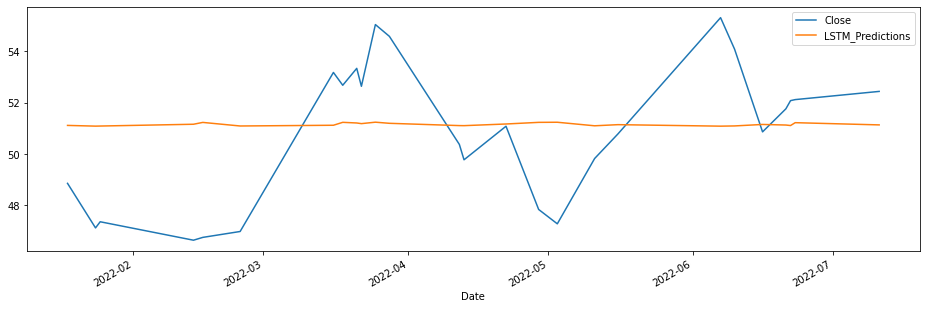

In [40]:
test_data['Close'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [41]:
lstm_rmse_error = rmse(test_data['Close'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 7.456499389472044
RMSE Error: 2.7306591492663532
Mean: 50.96569230769231


##  Double LSTM Model

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu',return_sequences=True,
                    input_shape=(n_input, n_features)))
lstm_model.add(LSTM(200, return_sequences=True))
lstm_model.add(Dropout(rate=0.2))
lstm_model.add(LSTM(200, return_sequences=False))
lstm_model.add(Dense(1))

mc = ModelCheckpoint('double_model_lstm.h5', monitor='val_loss', mode='min', 
                     verbose=1, save_best_only=True)

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 200)           161600    
                                                                 
 lstm_2 (LSTM)               (None, 24, 200)           320800    
                                                                 
 dropout (Dropout)           (None, 24, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [43]:
lstm_model.compile(optimizer='adam', loss='mse')

In [44]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
80/80 [==============================] - 10s 62ms/step - loss: 0.0994
Epoch 2/20
80/80 [==============================] - 5s 62ms/step - loss: 0.0807
Epoch 3/20
80/80 [==============================] - 5s 63ms/step - loss: 0.0838
Epoch 4/20
80/80 [==============================] - 7s 87ms/step - loss: 0.0789
Epoch 5/20
80/80 [==============================] - 5s 65ms/step - loss: 0.0791
Epoch 6/20
80/80 [==============================] - 5s 65ms/step - loss: 0.0750
Epoch 7/20
80/80 [==============================] - 5s 65ms/step - loss: 0.0744
Epoch 8/20
80/80 [==============================] - 5s 64ms/step - loss: 0.0764
Epoch 9/20
80/80 [==============================] - 5s 64ms/step - loss: 0.0795
Epoch 10/20
80/80 [==============================] - 5s 64ms/step - loss: 0.0752
Epoch 11/20
80/80 [==============================] - 5s 64ms/step - loss: 0.0807
Epoch 12/20
80/80 [==============================] - 5s 64ms/step - loss: 0.0754
Epoch 13/20
80/80 [=================

### EarlyStopping y Validation Generator 

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=12)

In [47]:
validation_generator = TimeseriesGenerator(scaled_test_data,scaled_test_data, 
                                           length=n_input)

In [48]:
lstm_model.compile(optimizer='adam', 
              loss='mse')

In [49]:
# fit model
lstm_model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop, mc])

Epoch 1/20
80/80 [==============================] - ETA: 0s - loss: 0.0818
Epoch 1: val_loss improved from inf to 0.16099, saving model to double_model_lstm.h5
80/80 [==============================] - 11s 79ms/step - loss: 0.0818 - val_loss: 0.1610
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 0.0744
Epoch 2: val_loss improved from 0.16099 to 0.16004, saving model to double_model_lstm.h5
80/80 [==============================] - 5s 66ms/step - loss: 0.0744 - val_loss: 0.1600
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 0.0762
Epoch 3: val_loss improved from 0.16004 to 0.15914, saving model to double_model_lstm.h5
80/80 [==============================] - 5s 67ms/step - loss: 0.0762 - val_loss: 0.1591
Epoch 4/20
80/80 [==============================] - ETA: 0s - loss: 0.0783
Epoch 4: val_loss did not improve from 0.15914
80/80 [==============================] - 5s 66ms/step - loss: 0.0783 - val_loss: 0.1612
Epoch 5/20
80/80 [===================

#### Learning curve

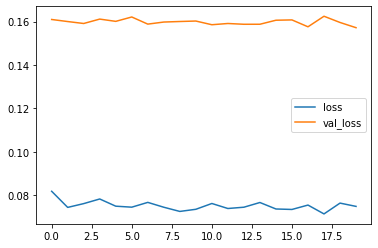

In [50]:
losses = pd.DataFrame(lstm_model.history.history)
losses.plot()

In [51]:
from keras.models import load_model

lstm_model = load_model('double_model_lstm.h5', compile=False)

## Prediction on test data

In [52]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    lstm_pred = lstm_model.predict(current_batch)[0]
    
    # store prediction
    lstm_predictions_scaled.append(lstm_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As you know, we scale our data, so we have to invert it to see true predictions.

### Reverse the transformation

In [53]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [54]:
test_data['LSTM_Predictions'] = lstm_predictions

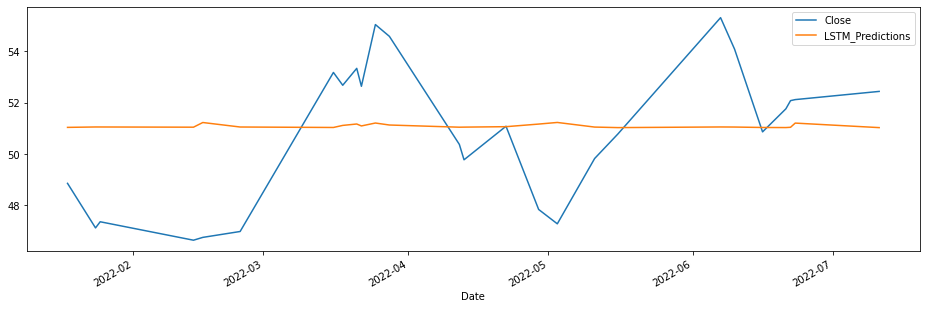

In [55]:
test_data['Close'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [56]:
lstm_rmse_error = rmse(test_data['Close'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 7.445708071463624
RMSE Error: 2.7286824790480155
Mean: 50.96569230769231


# Real Prediction of the Gas Price of the next week

Let us assume that we want to predict the price of the gas of the next week.

In [57]:
df.head()

,Close
Date,
2022-01-03,48.77
2022-01-04,49.35
2022-01-05,49.57
2022-01-06,49.54
2022-01-07,49.80


In [58]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [59]:
length = 7 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [60]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
123/123 [==============================] - 2s 5ms/step - loss: 0.0664
Epoch 2/8
123/123 [==============================] - 1s 4ms/step - loss: 0.0233
Epoch 3/8
123/123 [==============================] - 1s 5ms/step - loss: 0.0207
Epoch 4/8
123/123 [==============================] - 1s 4ms/step - loss: 0.0171
Epoch 5/8
123/123 [==============================] - 1s 4ms/step - loss: 0.0159
Epoch 6/8
123/123 [==============================] - 1s 4ms/step - loss: 0.0138
Epoch 7/8
123/123 [==============================] - 1s 4ms/step - loss: 0.0152
Epoch 8/8
123/123 [==============================] - 1s 4ms/step - loss: 0.0127


In [61]:
forecast = []
# Replace periods with whatever forecast length you want
#one week
periods = 7

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [62]:
forecast = scaler.inverse_transform(forecast)

In [63]:
test_data.tail()

,Close,LSTM_Predictions
Date,,
2022-06-10,54.09,51.048577
2022-02-24,46.97,51.049906
2022-01-25,47.35,51.050903
2022-01-24,47.11,51.051138
2022-06-07,55.32,51.051620


In [64]:
week_ago=addonDays(to_date, -7)

In [65]:
next_week=addonDays(to_date, 7)

In [66]:
next_month=addonDays(to_date, 30)

In [67]:
forecast_index = pd.date_range(start=to_date,periods=periods,freq='D')

In [68]:
forecast_index

DatetimeIndex(['2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-16', '2022-07-17'],
              dtype='datetime64[ns]', freq='D')

In [69]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

,Forecast
2022-07-11,51.813867
2022-07-12,51.555826
2022-07-13,51.414034
2022-07-14,51.184416
2022-07-15,50.964223
2022-07-16,50.823968
2022-07-17,50.682015


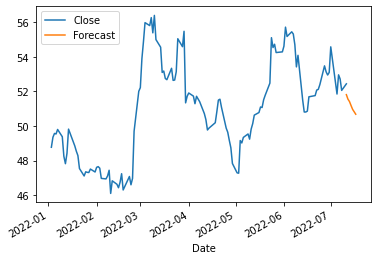

In [70]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [71]:
month_ago=addonDays(to_date, -30)

(738317.0, 738354.0)

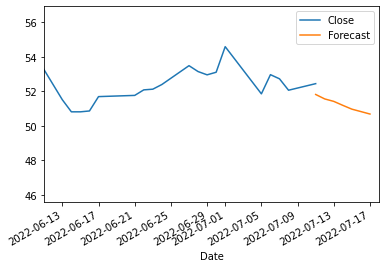

In [72]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim(month_ago,next_week)

In [73]:
fig3 = make_subplots(specs=[[{"secondary_y": True}]])
fig3.add_trace(go.Scatter(x=forecast_df.index,y=forecast_df['Forecast'],name='Forecast'))
fig3.add_trace(go.Scatter(x=df.index,y=df['Close'],name='Close'))
fig3.update_layout(title={'text':gas_result.name+' ('+ default_currency +')', 'x':0.5})
fig3.update_yaxes(range=[0,1000000000],secondary_y=True)
fig3.update_yaxes(visible=False, secondary_y=True)
fig3.update_layout(xaxis_rangeslider_visible=False)  #hide range slider
fig3.show()

**Congratulations!** We have created a Neural Network by using LST and we have predict the Natural Gas for one week.